In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Augmentation

### Method #1

In [ ]:
import os
import random
import numpy as np
import open3d as o3d

# ------------------------------------------------
# Augmentation functions
# ------------------------------------------------

def random_rotation(points):
    """
    Apply a random rotation about a random axis in 3D.
    points: (N, 3) numpy array
    return: rotated points (N, 3)
    """
    # Generate random angles for rotations about X, Y, Z
    rx = np.random.uniform(0, 2*np.pi)
    ry = np.random.uniform(0, 2*np.pi)
    rz = np.random.uniform(0, 2*np.pi)

    # Rotation matrices for each axis
    Rx = np.array([
        [1,           0,            0],
        [0,  np.cos(rx), -np.sin(rx)],
        [0,  np.sin(rx),  np.cos(rx)]
    ])
    Ry = np.array([
        [ np.cos(ry), 0,  np.sin(ry)],
        [          0, 1,           0],
        [-np.sin(ry), 0,  np.cos(ry)]
    ])
    Rz = np.array([
        [ np.cos(rz), -np.sin(rz), 0],
        [ np.sin(rz),  np.cos(rz), 0],
        [          0,           0, 1]
    ])

    # Combined rotation
    R = Rz @ Ry @ Rx
    return points @ R.T


def random_scaling(points, scale_range=(0.8, 1.2)):
    """
    Scale the point cloud by a random factor.
    scale_range: (min_scale, max_scale)
    return: scaled points (N, 3)
    """
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return points * scale_factor


def random_jitter(points, sigma=0.01, clip=0.05):
    """
    Jitter each point by Gaussian noise (mean=0, std=sigma) clipped to +/- clip.
    return: jittered points (N, 3)
    """
    jitter = np.clip(sigma * np.random.randn(*points.shape), -clip, clip)
    return points + jitter


def random_mixup(pc1, pc2, alpha=0.5):
    """
    Mixup: randomly merge points from two point clouds.
    alpha ~ fraction from pc1 or ratio if you want partial merges.
    Here we take alpha% of points from pc1 and (1-alpha)% from pc2.
    """
    n1 = int(len(pc1) * alpha)
    n2 = 4096 - n1  # ensuring total 4096
    # Randomly sample points from pc1, pc2
    idx1 = np.random.choice(len(pc1), n1, replace=(n1 > len(pc1)))
    idx2 = np.random.choice(len(pc2), n2, replace=(n2 > len(pc2)))
    return np.concatenate([pc1[idx1], pc2[idx2]], axis=0)


def random_cutmix(pc1, pc2):
    """
    CutMix for point clouds (conceptually):
    1. Random bounding box on pc1
    2. Replace those points by points from pc2 within a bounding box.
    Return combined pc with same number of points.
    """
    # For demonstration, let's randomly choose half the points from pc1
    # that lie within a random bounding region, and replace them with
    # an equal number of points from pc2 in the same bounding region.
    N = 4096
    # First sample both to 4096 (if they aren't already)
    pc1_sample = uniform_resample(pc1, N)
    pc2_sample = uniform_resample(pc2, N)

    # Random bounding box (small cube) in pc1:
    center = np.mean(pc1_sample, axis=0)
    offset = np.random.uniform(low=0.0, high=0.1, size=3)
    min_box = center - offset
    max_box = center + offset

    # Indices in pc1 that lie inside the bounding box
    inside_box = np.all((pc1_sample >= min_box) & (pc1_sample <= max_box), axis=1)
    inside_count = np.sum(inside_box)

    # Indices in pc2 to replace them
    idx_replace = np.random.choice(len(pc2_sample), inside_count, replace=(inside_count>len(pc2_sample)))

    # Output
    pc_out = pc1_sample.copy()
    pc_out[inside_box] = pc2_sample[idx_replace]
    return pc_out


def elastic_distortion(points, granularity=0.2, magnitude=0.4):
    """
    Simple approximation of elastic distortion:
    1. Generate random 3D displacement fields (Perlin noise or random).
    2. Shift points accordingly.
    Here, we do a simple random displacement for demonstration.
    """
    # For a more realistic approach, you'd sample from a coherent noise function.
    # We'll do a simpler random offset approach grouped by 'granularity'.
    # This is very simplistic. 
    coords = points / granularity
    coords_floor = np.floor(coords).astype(np.int32)
    offsets = {}
    distorted_points = []

    for i, c in enumerate(coords_floor):
        c_key = tuple(c)
        if c_key not in offsets:
            offsets[c_key] = np.random.uniform(-magnitude, magnitude, size=3)
        distorted_points.append(points[i] + offsets[c_key])

    return np.array(distorted_points)


def occlusion_simulation(points, drop_ratio=0.2):
    """
    Randomly simulate occlusion by removing a fraction of points 
    (e.g. all points in some random bounding region).
    """
    N = len(points)
    # We remove (drop_ratio * N) points in a random bounding region
    # Example: remove points within a random sphere
    center_idx = np.random.choice(N, 1)
    center = points[center_idx]
    radius = np.random.uniform(0.1, 0.3)

    dist = np.linalg.norm(points - center, axis=1)
    inside_sphere = dist < radius

    # If fewer points are inside than we want to remove, 
    # we might remove them all; otherwise remove only portion.
    num_remove = int(drop_ratio * N)
    inside_indices = np.where(inside_sphere)[0]

    if len(inside_indices) <= num_remove:
        # Remove them all
        keep_mask = ~inside_sphere
    else:
        # Random subset of inside_sphere
        remove_indices = np.random.choice(inside_indices, num_remove, replace=False)
        keep_mask = np.ones(N, dtype=bool)
        keep_mask[remove_indices] = False

    return points[keep_mask]


def uniform_resample(points, num_samples=4096):
    """
    Uniformly (randomly) sample (or downsample) points to a fixed number.
    If points < num_samples, replicate some points.
    """
    N = len(points)
    if N > num_samples:
        # Downsample
        idx = np.random.choice(N, num_samples, replace=False)
        return points[idx]
    elif N < num_samples:
        # Upsample
        idx = np.random.choice(N, num_samples, replace=True)
        return points[idx]
    else:
        return points

# ------------------------------------------------
# Main pipeline that applies all augmentations
# ------------------------------------------------

def augment_point_cloud(pc, all_pcs):
    """
    A demonstration pipeline that does:
    1) Random rotation
    2) Random scaling
    3) Random jitter
    4) Optionally MixUp with another random cloud
    5) Optionally CutMix with another random cloud
    6) Elastic Distortion
    7) Occlusion Simulation
    8) Resample to 4096
    """
    # 1) Rotate
    pc = random_rotation(pc)
    # 2) Scale
    pc = random_scaling(pc)
    # 3) Jitter
    pc = random_jitter(pc)

    # 4) MixUp with probability 0.5
    if random.random() < 0.5 and len(all_pcs) > 1:
        # pick a different random cloud
        pc2 = random.choice(all_pcs)
        if not np.array_equal(pc2, pc):
            pc2 = uniform_resample(pc2, 4096)
            pc = random_mixup(uniform_resample(pc, 4096), pc2)

    # 5) CutMix with probability 0.5
    if random.random() < 0.5 and len(all_pcs) > 1:
        pc2 = random.choice(all_pcs)
        if not np.array_equal(pc2, pc):
            pc = random_cutmix(pc, pc2)

    # 6) Elastic Distortion
    pc = elastic_distortion(pc)

    # 7) Occlusion Simulation (with probability 0.5)
    if random.random() < 0.5:
        pc = occlusion_simulation(pc, drop_ratio=0.2)

    # 8) Always resample to 4096 at the end
    pc = uniform_resample(pc, 4096)

    return pc

def load_ply_as_numpy(filepath):
    """
    Load a .ply file using Open3D and return Nx3 numpy array of points.
    """
    pcd = o3d.io.read_point_cloud(filepath)
    return np.asarray(pcd.points)

def save_numpy_as_ply(points, filepath):
    """
    Save an Nx3 numpy array of points to PLY using Open3D.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(filepath, pcd)

# ------------------------------------------------
# Main entry point
# ------------------------------------------------

def main(input_folder=r'buildings_pointcloud_ply',
         output_folder=r'augmented_buildings_ply'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Gather all PLY files in input folder
    ply_files = [f for f in os.listdir(input_folder) if f.endswith('.ply')]

    # Pre-load all point clouds into memory for potential MixUp/CutMix
    all_point_clouds = []
    for fname in ply_files:
        full_path = os.path.join(input_folder, fname)
        pc = load_ply_as_numpy(full_path)
        all_point_clouds.append(pc)

    # Augment each file
    for i, fname in enumerate(ply_files):
        input_path = os.path.join(input_folder, fname)
        output_path = os.path.join(output_folder,"aug_"+fname)

        # Load
        pc = all_point_clouds[i]

        # Augment
        pc_aug = augment_point_cloud(pc, all_point_clouds)

        # Save
        save_numpy_as_ply(pc_aug, output_path)
        print(f"Saved augmented point cloud to {output_path}")

if __name__ == "__main__":
    main()


### Method 2

In [ ]:
import os
import numpy as np
import open3d as o3d
import random
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter

# Input and output directories
input_dir = "buildings_pointcloud_ply"
output_dir = "augmented_v2_buildings_ply"
os.makedirs(output_dir, exist_ok=True)

def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)
    return points, pcd

def save_point_cloud(points, template_pcd, output_path):
    template_pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(output_path, template_pcd)

def random_rotation(points):
    rot = R.random().as_matrix()
    return points @ rot.T

def random_scaling(points, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(*scale_range)
    return points * scale

def random_jittering(points, sigma=0.02, clip=0.05):
    jitter = np.clip(np.random.normal(0, sigma, points.shape), -clip, clip)
    return points + jitter

def mixup(points1, points2):
    alpha = np.random.beta(0.4, 0.4)  # Mixup parameter
    mixed_points = alpha * points1 + (1 - alpha) * points2
    return mixed_points

def cutmix(points1, points2):
    mask = np.random.rand(points1.shape[0]) > 0.5
    mixed_points = np.where(mask[:, None], points1, points2)
    return mixed_points

def elastic_distortion(points, sigma=0.2, magnitude=0.2):
    noise = np.random.randn(*points.shape) * sigma
    smoothed_noise = gaussian_filter(noise, sigma=magnitude, mode='constant')
    return points + smoothed_noise

def occlusion_simulation(points, occlusion_ratio=0.2):
    keep_indices = np.random.choice(points.shape[0], int((1 - occlusion_ratio) * points.shape[0]), replace=False)
    return points[keep_indices]

# Process each PLY file in the directory
file_list = [f for f in os.listdir(input_dir) if f.endswith(".ply")]

for file_name in file_list:
    file_path = os.path.join(input_dir, file_name)
    points, pcd_template = load_point_cloud(file_path)

    # Perform augmentations
    augmented_variants = {
        "rotated": random_rotation(points),
        "scaled": random_scaling(points),
        "jittered": random_jittering(points),
        "elastic": elastic_distortion(points),
    }

    # Select another random file for mixup and cutmix
    mixup_file = random.choice(file_list)
    cutmix_file = random.choice(file_list)
    mixup_points, _ = load_point_cloud(os.path.join(input_dir, mixup_file))
    cutmix_points, _ = load_point_cloud(os.path.join(input_dir, cutmix_file))

    augmented_variants["mixup"] = mixup(points, mixup_points[:4096])
    augmented_variants["cutmix"] = cutmix(points, cutmix_points[:4096])
    augmented_variants["occluded"] = occlusion_simulation(points)

    # Ensure all augmented point clouds have exactly 4096 points
    for key, aug_points in augmented_variants.items():
        if aug_points.shape[0] < 4096:
            aug_points = np.pad(aug_points, ((0, 4096 - aug_points.shape[0]), (0, 0)), mode='edge')
        elif aug_points.shape[0] > 4096:
            aug_points = aug_points[:4096]

        output_path = os.path.join(output_dir, f"aug_{key}{file_name[:-4]}.ply")
        save_point_cloud(aug_points, pcd_template, output_path)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Encoder

In [5]:
class PointNetPPEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(PointNetPPEncoder, self).__init__()
        self.latent_dim = latent_dim

        # Shared MLPs for local feature extraction
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, 512, 1)
        self.conv5 = nn.Conv1d(512, 1024, 1)
        self.conv6 = nn.Conv1d(1024, 2048, 1)

        # Fully connected layers for global features
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)       # Mean of latent distribution
        self.fc_log_sigma = nn.Linear(256, latent_dim)  # Log variance of latent distribution

    def forward(self, x):
        # Input x: (batch_size, num_points, 3)
        x = x.permute(0, 2, 1)  # Change to (batch_size, 3, num_points)

        # Apply shared MLPs
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # Global max pooling
        x = torch.max(x, dim=2)[0]  # (batch_size, 256)

        # Fully connected layers for latent representation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc_mu(x)           # (batch_size, latent_dim)
        log_sigma = self.fc_log_sigma(x)  # (batch_size, latent_dim)
        return mu, log_sigma

Decoder

In [6]:
class PointNetPPDecoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=4096):
        super(PointNetPPDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_points = num_points

        # Fully connected layers to create an initial coarse point cloud
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)  # Coarse point cloud (e.g., 256 points * 3)

        # Upsampling layers for finer details
        self.fc4 = nn.Linear(1024, 2048)
        self.fc5 = nn.Linear(2048, 4096)
        self.fc6 = nn.Linear(4096, num_points * 3) # Final high-resolution output

    def forward(self, z):
        # Input z: (batch_size, latent_dim)
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # Coarse point cloud

        # Upsample to finer resolution
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # (batch_size, num_points * 3)

        # Reshape to point cloud format
        x = x.view(-1, self.num_points, 3)  # (batch_size, num_points, 3)
        return x

Reparameterization trick

In [7]:
def reparameterize(mu, log_sigma):
    """
    Reparameterization trick to sample latent variable z.
    z = mu + eps * exp(log_sigma * 0.5)
    """
    std = torch.exp(0.5 * log_sigma)
    epsilon = torch.randn_like(std)
    return mu + epsilon * std

Encoder + Decoder + Reparameterization Trick = Autoencoder (in our case, Variational Autoencoder because we have mu and log sigma)

In [8]:
class PointNetPPAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=4096):
        super(PointNetPPAutoencoder, self).__init__()
        self.encoder = PointNetPPEncoder(latent_dim)
        self.decoder = PointNetPPDecoder(latent_dim, num_points)

    def forward(self, x):
        """
        Returns:
          reconstructed: (batch_size, num_points, 3)
          mu: (batch_size, latent_dim)
          log_sigma: (batch_size, latent_dim)
        """
        mu, log_sigma = self.encoder(x)
        z = reparameterize(mu, log_sigma)  # <-- Use the reparam trick
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_sigma

Loss Functions

In [9]:
def chamfer_distance(x, y):
    """
    Compute Chamfer Distance between two point clouds x and y.
    """
    x_expanded = x.unsqueeze(2)  # (batch_size, num_points_x, 1, 3)
    y_expanded = y.unsqueeze(1)  # (batch_size, 1, num_points_y, 3)
    distances = torch.norm(x_expanded - y_expanded, dim=3)  # Pairwise distances
    min_dist_x = torch.min(distances, dim=2)[0]
    min_dist_y = torch.min(distances, dim=1)[0]
    return torch.mean(min_dist_x) + torch.mean(min_dist_y)

def kl_divergence(mu, log_sigma):
    """
    Compute the KL divergence between the encoder's latent distribution and a standard Gaussian.
    Args:
        mu: Mean of the latent distribution (batch_size, latent_dim)
        log_sigma: Log of standard deviation (batch_size, latent_dim)
    Returns:
        kl_loss: The KL divergence loss (scalar)
    """
    kl_loss = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp(), dim=1)
    return torch.mean(kl_loss)  # Return the batch mean

In [7]:
!pip install open3d


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch
import torch.utils.data as data
import open3d as o3d
import os
import numpy as np
from torch.utils.data import random_split

class PointCloudDataset(data.Dataset):
    def __init__(self, folder_path, num_points=4096):
        self.folder_path = folder_path
        self.num_points = num_points
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.ply')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        pcd = o3d.io.read_point_cloud(file_path)
        points = np.asarray(pcd.points)

        # Scale and center the point cloud to fit within a unit cube or sphere:
        points -= np.mean(points, axis=0)  # Center
        # points /= np.max(np.linalg.norm(points, axis=1))  # I chose not to scale since I would like to see if my latent space can predict for height

        # Randomly sample or pad points to ensure uniformity
        if points.shape[0] > self.num_points:
            indices = np.random.choice(points.shape[0], self.num_points, replace=False)
            points = points[indices]
        elif points.shape[0] < self.num_points:
            pad_size = self.num_points - points.shape[0]
            pad_points = np.zeros((pad_size, 3))
            points = np.vstack((points, pad_points))

        return torch.tensor(points, dtype=torch.float32)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Data Loader

In [9]:
import torch
from torch.utils.data import random_split

def get_data_loaders(folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
                     num_points=4096,
                     batch_size=32,
                     train_ratio=0.9,
                     random_seed=42):  # Added a seed parameter for reproducibility
    # Set the random seed for reproducibility
    torch.manual_seed(random_seed)

    dataset = PointCloudDataset(folder_path, num_points=num_points)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Dataset split: {len(train_dataset)} train samples, {len(test_dataset)} test samples")
    return train_loader, test_loader



Define Training Loop

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

def train_model(folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
                latent_dim=128,
                num_points=4096,
                batch_size=16,
                num_epochs=50,
                learning_rate=0.001,
                beta=1.0,
                device="cpu"):

    # Prepare data
    train_loader, test_loader = get_data_loaders(
        folder_path=folder_path,
        num_points=num_points,
        batch_size=batch_size,
        train_ratio=0.9
    )

    # Initialize model
    model = PointNetPPAutoencoder(latent_dim=latent_dim, num_points=num_points)
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for batch in progress_bar:
            batch = batch.to(device)

            optimizer.zero_grad()

            # Forward pass (with VAE components)
            reconstructed, mu, log_sigma = model(batch)

            # Compute losses
            recon_loss = chamfer_distance(reconstructed, batch)
            kld_loss = kl_divergence(mu, log_sigma)

            # Total loss (VAE) (which is equal to B=1)
            loss = recon_loss + kld_loss

            # Total loss (beta-VAE)
            # loss = recon_loss + beta * kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"Batch Loss": loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

        # Save the trained model
        model_save_path = "pointnetpp_VAE.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")



    # Plot loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
    plt.title("Training Loss Over Epochs (Chamfer + KL)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

Train

Dataset split: 3606 train samples, 401 test samples
Starting training...


Epoch 1/50: 100%|██████████| 226/226 [48:50<00:00, 12.97s/it, Batch Loss=5.87]


Epoch 1/50, Loss: 5.4949
Model saved to pointnetpp_VAE.pth


Epoch 2/50: 100%|██████████| 226/226 [00:22<00:00,  9.86it/s, Batch Loss=6.72]


Epoch 2/50, Loss: 4.9826
Model saved to pointnetpp_VAE.pth


Epoch 3/50: 100%|██████████| 226/226 [00:24<00:00,  9.41it/s, Batch Loss=7.43]


Epoch 3/50, Loss: 5.0797
Model saved to pointnetpp_VAE.pth


Epoch 4/50: 100%|██████████| 226/226 [00:23<00:00,  9.45it/s, Batch Loss=12.1]


Epoch 4/50, Loss: 4.9152
Model saved to pointnetpp_VAE.pth


Epoch 5/50: 100%|██████████| 226/226 [00:23<00:00,  9.52it/s, Batch Loss=4.43]


Epoch 5/50, Loss: 5.0297
Model saved to pointnetpp_VAE.pth


Epoch 6/50: 100%|██████████| 226/226 [00:23<00:00,  9.52it/s, Batch Loss=4.74]


Epoch 6/50, Loss: 4.8606
Model saved to pointnetpp_VAE.pth


Epoch 7/50: 100%|██████████| 226/226 [00:23<00:00,  9.50it/s, Batch Loss=6.5]


Epoch 7/50, Loss: 4.9394
Model saved to pointnetpp_VAE.pth


Epoch 8/50: 100%|██████████| 226/226 [00:23<00:00,  9.56it/s, Batch Loss=4.67]


Epoch 8/50, Loss: 4.8016
Model saved to pointnetpp_VAE.pth


Epoch 9/50: 100%|██████████| 226/226 [00:23<00:00,  9.50it/s, Batch Loss=3.31]


Epoch 9/50, Loss: 4.7959
Model saved to pointnetpp_VAE.pth


Epoch 10/50: 100%|██████████| 226/226 [00:23<00:00,  9.55it/s, Batch Loss=3.44]


Epoch 10/50, Loss: 4.6817
Model saved to pointnetpp_VAE.pth


Epoch 11/50: 100%|██████████| 226/226 [00:23<00:00,  9.72it/s, Batch Loss=2.88]


Epoch 11/50, Loss: 4.7010
Model saved to pointnetpp_VAE.pth


Epoch 12/50: 100%|██████████| 226/226 [00:23<00:00,  9.58it/s, Batch Loss=3.65]


Epoch 12/50, Loss: 4.7372
Model saved to pointnetpp_VAE.pth


Epoch 13/50: 100%|██████████| 226/226 [00:23<00:00,  9.53it/s, Batch Loss=5.35]


Epoch 13/50, Loss: 4.7096
Model saved to pointnetpp_VAE.pth


Epoch 14/50: 100%|██████████| 226/226 [00:23<00:00,  9.55it/s, Batch Loss=3.34]


Epoch 14/50, Loss: 4.6883
Model saved to pointnetpp_VAE.pth


Epoch 15/50: 100%|██████████| 226/226 [00:23<00:00,  9.55it/s, Batch Loss=5.02]


Epoch 15/50, Loss: 4.7152
Model saved to pointnetpp_VAE.pth


Epoch 16/50: 100%|██████████| 226/226 [00:23<00:00,  9.52it/s, Batch Loss=3.95]


Epoch 16/50, Loss: 4.6784
Model saved to pointnetpp_VAE.pth


Epoch 17/50: 100%|██████████| 226/226 [00:23<00:00,  9.75it/s, Batch Loss=3.9]


Epoch 17/50, Loss: 4.6591
Model saved to pointnetpp_VAE.pth


Epoch 18/50: 100%|██████████| 226/226 [00:23<00:00,  9.62it/s, Batch Loss=3.32]


Epoch 18/50, Loss: 4.7275
Model saved to pointnetpp_VAE.pth


Epoch 19/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=2.43]


Epoch 19/50, Loss: 4.6416
Model saved to pointnetpp_VAE.pth


Epoch 20/50: 100%|██████████| 226/226 [00:23<00:00,  9.62it/s, Batch Loss=3.5]


Epoch 20/50, Loss: 4.6505
Model saved to pointnetpp_VAE.pth


Epoch 21/50: 100%|██████████| 226/226 [00:23<00:00,  9.65it/s, Batch Loss=3.14]


Epoch 21/50, Loss: 4.6469
Model saved to pointnetpp_VAE.pth


Epoch 22/50: 100%|██████████| 226/226 [00:23<00:00,  9.60it/s, Batch Loss=5.25]


Epoch 22/50, Loss: 4.6665
Model saved to pointnetpp_VAE.pth


Epoch 23/50: 100%|██████████| 226/226 [00:23<00:00,  9.62it/s, Batch Loss=5.02]


Epoch 23/50, Loss: 4.6569
Model saved to pointnetpp_VAE.pth


Epoch 24/50: 100%|██████████| 226/226 [00:23<00:00,  9.61it/s, Batch Loss=2.72]


Epoch 24/50, Loss: 4.6225
Model saved to pointnetpp_VAE.pth


Epoch 25/50: 100%|██████████| 226/226 [00:23<00:00,  9.58it/s, Batch Loss=3.62]


Epoch 25/50, Loss: 4.6415
Model saved to pointnetpp_VAE.pth


Epoch 26/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=4.63]


Epoch 26/50, Loss: 4.6094
Model saved to pointnetpp_VAE.pth


Epoch 27/50: 100%|██████████| 226/226 [00:23<00:00,  9.54it/s, Batch Loss=4.23]


Epoch 27/50, Loss: 4.6447
Model saved to pointnetpp_VAE.pth


Epoch 28/50: 100%|██████████| 226/226 [00:23<00:00,  9.64it/s, Batch Loss=4.3]


Epoch 28/50, Loss: 4.6859
Model saved to pointnetpp_VAE.pth


Epoch 29/50: 100%|██████████| 226/226 [00:23<00:00,  9.51it/s, Batch Loss=5.67]


Epoch 29/50, Loss: 4.6141
Model saved to pointnetpp_VAE.pth


Epoch 30/50: 100%|██████████| 226/226 [00:23<00:00,  9.56it/s, Batch Loss=3.69]


Epoch 30/50, Loss: 4.6378
Model saved to pointnetpp_VAE.pth


Epoch 31/50: 100%|██████████| 226/226 [00:23<00:00,  9.58it/s, Batch Loss=12.2]


Epoch 31/50, Loss: 4.6368
Model saved to pointnetpp_VAE.pth


Epoch 32/50: 100%|██████████| 226/226 [00:23<00:00,  9.57it/s, Batch Loss=3.29]


Epoch 32/50, Loss: 4.6461
Model saved to pointnetpp_VAE.pth


Epoch 33/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=4]


Epoch 33/50, Loss: 4.6188
Model saved to pointnetpp_VAE.pth


Epoch 34/50: 100%|██████████| 226/226 [00:23<00:00,  9.55it/s, Batch Loss=3.96]


Epoch 34/50, Loss: 4.5937
Model saved to pointnetpp_VAE.pth


Epoch 35/50: 100%|██████████| 226/226 [00:23<00:00,  9.62it/s, Batch Loss=3.15]


Epoch 35/50, Loss: 4.5744
Model saved to pointnetpp_VAE.pth


Epoch 36/50: 100%|██████████| 226/226 [00:23<00:00,  9.55it/s, Batch Loss=6.69]


Epoch 36/50, Loss: 4.6877
Model saved to pointnetpp_VAE.pth


Epoch 37/50: 100%|██████████| 226/226 [00:23<00:00,  9.58it/s, Batch Loss=3.39]


Epoch 37/50, Loss: 4.6103
Model saved to pointnetpp_VAE.pth


Epoch 38/50: 100%|██████████| 226/226 [00:23<00:00,  9.63it/s, Batch Loss=3.17]


Epoch 38/50, Loss: 4.6172
Model saved to pointnetpp_VAE.pth


Epoch 39/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=3.51]


Epoch 39/50, Loss: 4.6195
Model saved to pointnetpp_VAE.pth


Epoch 40/50: 100%|██████████| 226/226 [00:23<00:00,  9.68it/s, Batch Loss=7.05]


Epoch 40/50, Loss: 4.6070
Model saved to pointnetpp_VAE.pth


Epoch 41/50: 100%|██████████| 226/226 [00:23<00:00,  9.57it/s, Batch Loss=6.1]


Epoch 41/50, Loss: 4.6137
Model saved to pointnetpp_VAE.pth


Epoch 42/50: 100%|██████████| 226/226 [00:23<00:00,  9.57it/s, Batch Loss=9.97]


Epoch 42/50, Loss: 4.5620
Model saved to pointnetpp_VAE.pth


Epoch 43/50: 100%|██████████| 226/226 [00:23<00:00,  9.61it/s, Batch Loss=4.48]


Epoch 43/50, Loss: 4.6115
Model saved to pointnetpp_VAE.pth


Epoch 44/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=4.28]


Epoch 44/50, Loss: 4.6042
Model saved to pointnetpp_VAE.pth


Epoch 45/50: 100%|██████████| 226/226 [00:23<00:00,  9.69it/s, Batch Loss=3.51]


Epoch 45/50, Loss: 4.5717
Model saved to pointnetpp_VAE.pth


Epoch 46/50: 100%|██████████| 226/226 [00:23<00:00,  9.59it/s, Batch Loss=4.07]


Epoch 46/50, Loss: 4.5837
Model saved to pointnetpp_VAE.pth


Epoch 47/50: 100%|██████████| 226/226 [00:23<00:00,  9.62it/s, Batch Loss=3.84]


Epoch 47/50, Loss: 4.5335
Model saved to pointnetpp_VAE.pth


Epoch 48/50: 100%|██████████| 226/226 [00:23<00:00,  9.57it/s, Batch Loss=4.33]


Epoch 48/50, Loss: 4.5788
Model saved to pointnetpp_VAE.pth


Epoch 49/50: 100%|██████████| 226/226 [00:23<00:00,  9.61it/s, Batch Loss=3.39]


Epoch 49/50, Loss: 4.5961
Model saved to pointnetpp_VAE.pth


Epoch 50/50: 100%|██████████| 226/226 [00:23<00:00,  9.60it/s, Batch Loss=4.14]


Epoch 50/50, Loss: 4.5606
Model saved to pointnetpp_VAE.pth


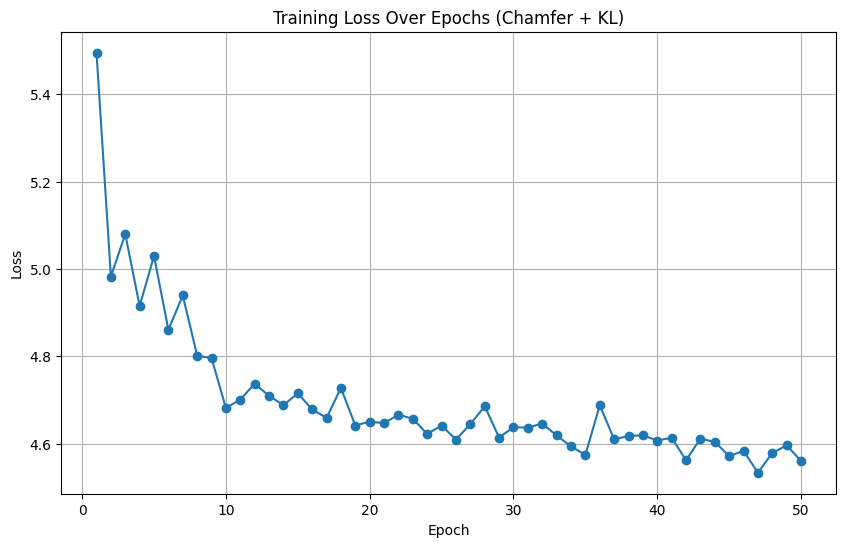

In [16]:
train_model(
    folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
    latent_dim=128,
    num_points=4096,
    batch_size=16,
    num_epochs=50,
    learning_rate=0.001,
    beta=1.0,
    device="cuda"  # or "cuda" if you have a GPU
)

In [11]:
import numpy as np
import open3d as o3d
import torch

def visualize_input_and_reconstructed(model, test_loader, device="cpu"):
    model.eval()

    with torch.no_grad():
        # Get the first batch from the test_loader
        for batch in test_loader:
            # Shape of batch: (batch_size, num_points, 3)
            batch = batch.to(device)
            break  # Just get the first batch

        # Let's visualize the first point cloud in this batch
        input_pc = batch[0]  # shape: (num_points, 3)
        input_np = input_pc.cpu().numpy()  # Convert to numpy for open3d

        # Encode and decode the point cloud
        mu, log_sigma = model.encoder(input_pc.unsqueeze(0))  # add batch dim => (1, num_points, 3)
        z = reparameterize(mu, log_sigma)
        reconstructed = model.decoder(z)  # shape: (1, num_points, 3)

        # Convert reconstructed to numpy
        reconstructed_np = reconstructed[0].cpu().numpy()

    # Create Open3D point cloud for the input
    pcd_input = o3d.geometry.PointCloud()
    pcd_input.points = o3d.utility.Vector3dVector(input_np)
    # Color the input cloud red
    pcd_input.paint_uniform_color([1.0, 0.0, 0.0])

    # Create Open3D point cloud for the reconstructed shape
    pcd_reconstructed = o3d.geometry.PointCloud()
    pcd_reconstructed.points = o3d.utility.Vector3dVector(reconstructed_np)
    # Color the reconstructed cloud green
    pcd_reconstructed.paint_uniform_color([0.0, 1.0, 0.0])

    # (Optional) Shift the reconstructed cloud so it’s easier to see side by side
    shift_along_x = 1.0
    pcd_reconstructed.translate((shift_along_x, 0, 0))

    # Visualize both point clouds together
    o3d.visualization.draw_geometries([pcd_input, pcd_reconstructed])

In [15]:
import open3d as o3d
import torch

model = PointNetPPAutoencoder(latent_dim=128, num_points=4096)
model.load_state_dict(torch.load("pointnetpp_VAE_with_Distance_Loss.pth", map_location=torch.device("cpu")))

model.to("cpu")  # or "cuda"

train_loader, test_loader = get_data_loaders(
    folder_path=r"C:\Users\Admin\PycharmProjects\AI-Projects\Tokyo-PointCloud\buildings_pointcloud_ply",
    num_points=4096,
    batch_size=4,  # or 1, if you want just one per batch
    train_ratio=0.9
)

visualize_input_and_reconstructed(model, test_loader, device="cpu")

Dataset split: 3606 train samples, 401 test samples
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [12]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load your trained (beta-)VAE model
# ---------------------------

# Load model
model = PointNetPPAutoencoder(latent_dim=128, num_points=4096)
model.load_state_dict(torch.load('pointnetpp_VAE.pth'))
model = model.to('cuda')  # Ensure the model is moved to GPU
model.eval()

# ---------------------------
# 2. Prepare (or load) the dataset
# ---------------------------
# Assuming train_loader yields only `inputs`, which are point clouds.
all_latents = []

for inputs in train_loader:  # No labels
    inputs = inputs.to('cuda')  # Use 'cuda' if you have a GPU and the model is on GPU
    with torch.no_grad():
        z_mean, z_logvar = model.encoder(inputs)  # Call the encoder directly

        # Sample from Gaussian distribution using reparameterization trick
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)  # Gaussian noise
        z_vec = z_mean + eps * std  # Sampled latent vector

    all_latents.append(z_vec.cpu().numpy())

all_latents = np.concatenate(all_latents, axis=0)  # shape: (N, latent_dim)

# ---------------------------
# 3. Apply t-SNE (or UMAP) to reduce dimensionality
# ---------------------------
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents)  # shape: (N, 2)

# ---------------------------
# 4. Plot the 2D t-SNE results
# ---------------------------
plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[:, 0], latents_2d[:, 1], s=5)  # No labels, so just plot the points
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_23424\1931494308.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pointnetpp_VAE.pth'))


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [12]:
model = PointNetPPAutoencoder(latent_dim=128, num_points=4096)
model.load_state_dict(torch.load("pointnetpp_VAE.pth", map_location=torch.device('cpu')))
model.eval()
dummy_input = torch.randn(1, 4096, 3)  # Adjust input shape based on your model
torch.onnx.export(model, dummy_input, "model.onnx", opset_version=11, input_names=["input"], output_names=["output"])
